### Shallow Aquifer model

This notebook runs a simple 1D model for groundwater flow and water table changes in a shallow aquifer above a horizontal impermeable unit. The model follows the Dupuit approximation, setting the hydraulic gradient equal to the water table gradient. 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

The basic source code for the model is here. You shouldn't need to modify it, but take a look to a get a sense for how it works.

In [2]:
class WaterTableSimulator(object):
    
    def __init__(self,
                 K = 100., # hydraulic conductivity (m/day)
                 R = 2e-3, # recharge rate (m/day)
                 H0 = 0.0, # initial height (m)
                 n = 50,   # number of nodes in the model
                 dx = 1.,  # spacing between nodes (m)
                 dt = 1e-4): # time step (days)

        self.hydraulic_conductivity = K
        self.recharge_rate = R
        self.init_height = H0
        self.init_time = 0
        self.nodes = n
        self.dx = dx
        self.dt = dt
        self.length = self.dx * self.nodes
        self.centers = np.arange(0.5*self.dx, self.length+self.dx, self.dx)
        self.H = 0 * self.centers + self.init_height
        self.H[-1] = 0
        self.u = 0 * self.centers
        self.q = 0 * self.centers
        
        # Construct an analytic solution for the steady state water table
        self.Hanalytic = np.sqrt(np.abs((R/K) * ((self.length + self.dx/2)**2 
                                                 - self.centers**2)))
        self.Qanalytic = self.centers * R
        self.Uanalytic = np.zeros(len(self.Qanalytic))
        self.Uanalytic[:-1] = self.Qanalytic[:-1] / self.Hanalytic[:-1]

        self.current_time = 0.0

    def run_one_step(self):
        """Run one time step."""
        self.dH = np.diff(self.H)      # differences in water table height btwn adjacent nodes
        self.dHdx = self.dH / self.dx  # water table gradient (= hydraulic gradient)
        self.u[1:] = -self.hydraulic_conductivity * self.dHdx  # Darcian velocity, m/day
        self.q[1:] = self.u[1:] * (self.H[:-1] + 0.5 * self.dH) # Unit discharge, m2/day
        self.dHdt = self.recharge_rate - np.diff(self.q) / self.dx # Rate of WT rise/fall, m/day
        self.H[:-1] += self.dHdt * self.dt  # New WT height for this time step, m
        self.current_time += self.dt   # Update current time

    def run_n_steps(self, n):
        for _ in range(n):
            self.run_one_step()
        print('Current time = ' + str(self.current_time))


In [3]:
def run_model(run_duration = 400.0,  # run duration (days)
                 K = 100., # hydraulic conductivity (m/day)
                 R = 2e-3, # recharge rate (m/day)
                 H0 = 0.0, # initial height (m)
                 n = 50,   # number of nodes in the model
                 dx = 1.,  # spacing between nodes (m)
                 dt = 1e-4, # time step (days)
                 plot_interval_in_days = 10,
             ):
    """Initialize, run, and display output from model.

    Parameters
    ----------
    """

    # Instantiate and initialize a simulator
    model = WaterTableSimulator(K=K, R=R, H0=H0, n=n, dx=dx, dt=dt)

    # Calculate number of animation iterations
    save_every = int(plot_interval_in_days / model.dt)
    nsteps = int(run_duration / plot_interval_in_days)

    # Set up a blank figure with placeholder lists for data
    fig, ax = plt.subplots()
    xdata = []
    ydata = []
    obj = ax.plot([], [], color = 'k')

    # Then, set up an initialization function
    def init():
        ax.set_ylim(0, 1.2 * np.amax(model.Hanalytic))
        ax.set_xlim(0, model.length)
        ax.set_ylabel('Height (m)')
        ax.set_xlabel('Distance (m)')
        return(obj)

    # Next, define the update function
    def update(i):
        ax.cla()
        model.run_n_steps(save_every)
        xdata = model.centers
        ydata = model.H
        ax.set_ylim(0, 1.2 * np.amax(model.Hanalytic))
        ax.set_xlim(0, model.length)
        ax.set_ylabel('Height (m)')
        ax.set_xlabel('Distance (m)')
        ax.set_title('Time = ' + str(round(model.current_time)) + ' days')
        obj = ax.plot(xdata, ydata)
        obj = ax.plot(xdata, model.Hanalytic, 'k--')
        return(obj)

    # Run the animation!
    print('Running...')
    anim = FuncAnimation(fig, update, nsteps, init_func=init, blit = True)

    # Convert the animation to HTML
    vid = HTML(anim.to_html5_video())
    
    print('done!')

    return vid, model

Running...
Current time = 9.999999999990033
Current time = 19.99999999996673
Current time = 29.999999999943423
Current time = 40.00000000020433
Current time = 50.000000000536296
Current time = 60.00000000086826
Current time = 70.00000000120022
Current time = 80.00000000153219
Current time = 90.00000000186415
Current time = 100.00000000219612
Current time = 110.00000000252808
Current time = 120.00000000286005
Current time = 130.000000003192
Current time = 140.00000000352398
Current time = 150.00000000385594
Current time = 160.0000000041879
Current time = 170.00000000451988
Current time = 180.00000000485184
Current time = 190.0000000051838
Current time = 200.00000000551577
Current time = 210.00000000584774
Current time = 220.0000000061797
Current time = 230.00000000651167
Current time = 240.00000000684363
Current time = 250.0000000071756
Current time = 260.00000000637067
Current time = 270.00000000386046
Current time = 280.00000000135026
Current time = 289.99999999884005
Current time = 2

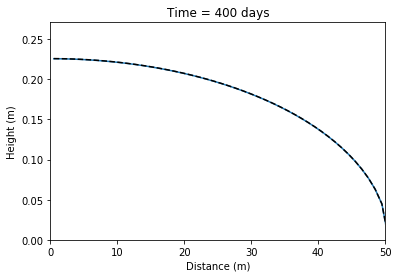

In [4]:
vid, model = run_model()
vid

Once you have completed a model run, you can view and plot the water table height (=saturated zone thickness), the Darcian velocity, the unit discharge, and other variables. The variable `centers` is a numpy array containing the $x$ coordinates of the cell centers. Here are some examples:

Text(0.5, 1.0, 'Final water table height')

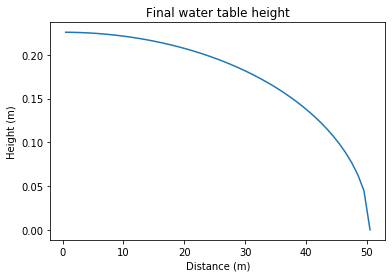

In [5]:
plt.plot(model.centers, model.H)
plt.xlabel('Distance (m)')
plt.ylabel('Height (m)')
plt.title('Final water table height')

Text(0.5, 1.0, 'Final flow velocity')

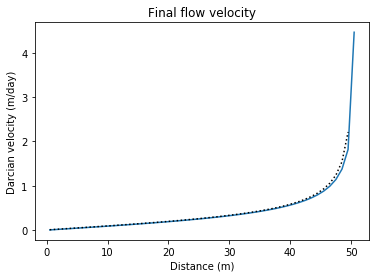

In [6]:
plt.plot(model.centers, model.u)
plt.plot(model.centers[:-1], model.Uanalytic[:-1], 'k:')  # note: last node undefined, don't plot
plt.xlabel('Distance (m)')
plt.ylabel('Darcian velocity (m/day)')
plt.title('Final flow velocity')

Text(0.5, 1.0, 'Final aquifer discharge')

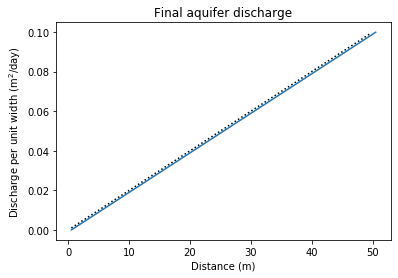

In [7]:
plt.plot(model.centers, model.q)
plt.plot(model.centers[:-1], model.Qanalytic[:-1], 'k:')  # note: last node undefined, don't plot
plt.xlabel('Distance (m)')
plt.ylabel(r'Discharge per unit width (m$^2$/day)')
plt.title('Final aquifer discharge')

## Your turn!

Use new cells below to run the model with different values of $K$, $R$, or other inputs. To change from the default value of a parameter, specify the name and value as keyword arguments to the `run_model` function. For example, to run the model with twice the default conductivity (that is, 200 m/day instead of 100 m/day), you would use `vid, model = run_model(K=200.0)`. To play the resulting movie, type `vid` on the last line or in a cell by itself. See the examples above for guidance on how to plot your data.

To get plots into your paper, you have a few options:

(1) Use the `savefig` matplotlib function to save your figures to files, and then import them into the notebook that contains your paper. For example, to save a plot as a file called `myplot.png`, use `savefig('myplot.png')` on a line of code right after your plotting commands.

(2) Copy the model code plus your runs at the end of your notebook, and use a markdown cell to give each figure a number and caption. Then you can refer to it in the main text.

(3) Take screen shots of your figures, and place them in the notebook containing your paper.

Whatever method you use, please remember to number your figures and include captions.